## Week 10

**Background**:
An important part of mathematical mdoeling is fitting compartmental models to observed data that is collected from a surveillance system. 
We can define fitting a model as estimating paraemters in the model based on observed data. 
To fit a model to data we need to complete---at minimum---two aims: (i) model validation and (ii) model fit. 

There are many different ways to validate a model. 


**Goals**:
This week we will validate a SIR model by performing two steps:
- Generate synthetic data from an SIR model where we know the true parameters. 
- Train our model on the synthetic data and ensure that our model recovers estimates that are close to the true, hidden parameters that we used to generate our data. 


Lets first use our code from Week 09 on the SIR model to produce a synthetic dataset.
We'll recover the number of incident cases from the system for a specific set of parameter values and assume that our dataset is generated by a sequence of Poisson distributed random variables. 

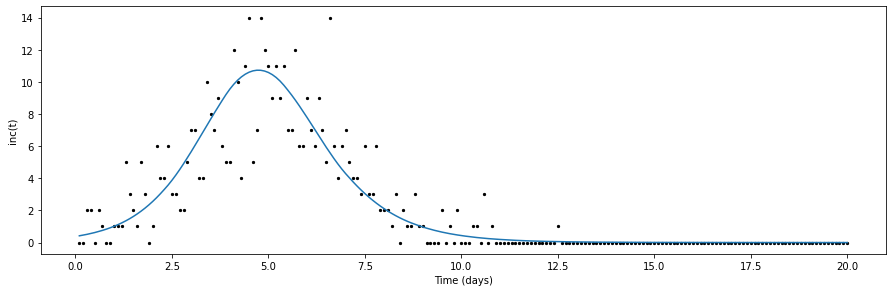

In [353]:
#--import packages
from scipy.integrate import solve_ivp

import numpy as np 
import matplotlib.pyplot as plt 

N = 1000 #--number of animals in system 

#--SIR differential equations
def sir(t,y, beta, gamma):
    s,i, r, c = y
    ds_dt = -beta*s*i
    di_dt = beta*s*i - gamma*i
    dr_dt = gamma*i
    
    dc_dt = beta*s*i #--incident cases
    return [ds_dt, di_dt, dr_dt, dc_dt]

#--start and end times 
start,end = 0., 20

#--times that we want to return s(t), i(t), r(t)
tvals = np.arange(start,end+0.1,0.1)

#--inital conditions for s, i, r
initial_conditions = (0.999, 0.001, 0., 0.001)

#--parameters for the model 
beta, gamma = 4, 1./(1./3)

#--function to return s,i,r over time
solution = solve_ivp( fun = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , t_eval = tvals
                     , args   = (beta, gamma))

#--extract from the solution object the times and a matrix of the three states
times  = solution.t
sir    = solution.y

#--compute incident cases
inc_cases = N*np.diff(sir[3,:])

#--add poisson noise
noisy_inc_cases = np.random.poisson(inc_cases)

#--draw i(t)
fig, ax = plt.subplots()
fig.set_size_inches(12.5,12.5/3)

ax.plot(times[1:]   ,inc_cases)
ax.scatter(times[1:],noisy_inc_cases, s=5, color="black")

#--set y and xlabel 
ax.set_xlabel("Time (days)", fontsize=10)
ax.set_ylabel("inc(t)", fontsize=10)

fig.set_tight_layout(True) #--adjust graph to fit labels

plt.show()

Now that we have a synthetic dataset called `noisy_inc` we can focus on an algorithm to fit our model to this dataset. 
The first algorithm that we will use is maximum likelihood estimation. 

**Setup**:
Suppose that we are handed a dataset of the number of incident cases which was collected over time from a surveillance system $\mathcal{D} = (y_{1},y_{2}, \cdots y_{t})$.
We can assume that this data was generated i.i.d from a sequence of Poisson distributed random variables 
$(Y_{1}, Y_{2}, \cdots, Y_{t})$ where 

\begin{align}
    Y_{i} \sim \textrm{Poisson}(\lambda(t))
\end{align}

and 

\begin{align}
    \lambda(t) = \textrm{inc}(t)
\end{align}

The variable $\textrm{inc}(t)$ is computed from our SIR model.

To compute the loglikelihood we will need to take the logarithm of the probability mass function for a poisson distributed random variable. 
The probability mass function (pmf) for a poisson distributed random variable $Y$ is 

\begin{align}
    P(Y=y) = e^{\lambda} \frac{\lambda^{y}}{y!}
\end{align}

The logarithm of the above pmf is 

\begin{align}
    \log \left[P(Y=y)\right] &= \log\left[e^{-\lambda} \frac{\lambda^{y}}{y!} \right]\\
                             &= -\lambda + y\log(\lambda) - \log(y!)
\end{align}

and so given parameters $(\lambda(1),\lambda(2), \cdots, \lambda(t) )$ the log likelihood for $t$ data points is 

\begin{align}
    \ell \ell (\lambda) &= \log \left [ P(y_{1}, y_{2}, \cdots, y_{t})  \right]   \\ 
    &= \log \left [ P(y_{1}) P(y_{2}) \cdots P(y_{t})  \right]  \; & \textrm{independence} \\ 
    &= \log \left [ P(y_{1})\right] +  \log \left [P(y_{2}) \right] + \cdots +  \log \left [P(y_{t}) \right]  \; & \textrm{log rules} \\ 
    &=  \sum_{i=1}^{t}\log \left [ P(y_{i})\right] \\ 
    &=  \sum_{i=1}^{t} -\lambda + y_{i}\log(\lambda) - \log(y_{i}!) \\ 
    \ell \ell (\lambda) &=  \sum_{i=1}^{t} -\lambda_{i} + y_{i}\log(\lambda_{i})  & \textrm{lambda does not impact y factorial} \\ 
\end{align}

The above $\lambda_{i}$ values are our incident cases generated by our SIR model. 

\begin{align}
    \ell \ell (\lambda) &=  \sum_{i=1}^{t} -\lambda_{i} + y_{i}\log(\lambda_{i}) \\ 
    &= \sum_{i=1}^{t} -\textrm{inc}(i) + y_{i}\log(\textrm{inc}(i))
\end{align}

Our goal then is to find the parameters $\theta = (\beta, \gamma)$ that maximize the loglikelihood or 

\begin{align}
    \max_{\theta} \ell \ell (\theta | \mathcal{D}) 
\end{align}

Instead of maximizing the loglikelihood we can equivalently minimize the **negative** loglikelihood. 

\begin{align}
    \max_{\theta} \ell \ell (\theta | \mathcal{D}) = \min_{\theta} -\ell \ell (\theta | \mathcal{D}) 
\end{align}

We can use a function called `minimize` from `scipy.optimize` to minimize the negative loglikelihood. 
Documentation for the minimize function is here = [https://docs.scipy.org/doc/scipy/tutorial/optimize.html](https://docs.scipy.org/doc/scipy/tutorial/optimize.html). 

In [354]:
from scipy.optimize import minimize #--import minimize function 

The minimize function takes two required arguments:
- A function to minimize (for us the negative loglikelihood) that takes as input a vector of parameters (for us this is beta and gamma)
- A starting point for the parameters values that we wish to optimize.

We will also provide this function an optional argument called `args` and will input into this argument our data, a vector of incident cases. 

#### First we should bundle our SIR model so that we incput paraemters and output incident cases. 

In [355]:
def generate_proposed_inc_cases(beta_gamma, N, inital_conditions, start_end):
    import numpy as np 
    from scipy.integrate import solve_ivp
        
    #--SIR differential equations
    def sir(t,y, beta, gamma):
        s,i, r, c = y
        ds_dt = -beta*s*i
        di_dt = beta*s*i - gamma*i
        dr_dt = gamma*i

        dc_dt = beta*s*i #--incident cases
        return [ds_dt, di_dt, dr_dt, dc_dt]
    
    #--lets assume we will always want step sizes of 0.1
    start,end = start_end
    tvals = np.arange(start, end+0.1, 0.1)
    
    #--parse arguments from function 
    beta,gamma = beta_gamma

    #--function to return s,i,r over time
    solution = solve_ivp( fun = sir
                         , t_span = (start,end)
                         , y0     = initial_conditions
                         , t_eval = tvals
                         , args   = (beta, gamma))

    #--extract from the solution object the times and a matrix of the three states
    times  = solution.t
    sir    = solution.y

    #--compute incident cases
    inc_cases = N*np.diff(sir[3,:])

    return inc_cases

#### Second the function to compute the negative loglikelihood 

In [356]:
def nll(lambdas, data):
    import numpy as np 
    
    data    = data + np.finfo(float).eps
    lambdas = lambdas + np.finfo(float).eps
    
    #--computelog likelihood
    ll = -1.*np.sum(lambdas) + np.sum(data*np.log(lambdas))
    
    return float(-1*ll) #--return the negative log likelihood

#### Now we need to combine these two pieces together to minimize the negative log likelihood. 

In [357]:
def fit_model(beta_gamma_N       #--this is the argument that minimize will change and maximize 
             ,N
             ,inital_conditions  #--this argument and the one below are needed
             ,start_end
             ,data ):
    proposed_incident_cases = generate_proposed_inc_cases(beta_gamma_N,N, inital_conditions, start_end)
    return nll(proposed_incident_cases, data)

N                  = 1000 
initial_conditions = (0.999, 0.001, 0., 0.001)
start_end          = (0,20) 
data               = noisy_inc_cases 

results = minimize(fit_model
         ,x0   = (1.1,0.5)
         ,args = ( N, initial_conditions, start_end, data )
        )
print(results)

estimated_beta, estimated_gamma = results.x

      fun: -332.7436032027749
 hess_inv: array([[1.33841287e-04, 5.20370556e-06],
       [5.20370556e-06, 1.41516764e-04]])
      jac: array([-7.62939453e-06,  5.72204590e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 75
      nit: 19
     njev: 25
   status: 2
  success: False
        x: array([3.92173156, 2.96216227])


Lets compare how well our maximum likelihood estimate compares to the truth. 
We can plot the true number of incident cases, poisson distributed data, and then an SIR model that is generated from our estimated beta and estimatd gamma. 

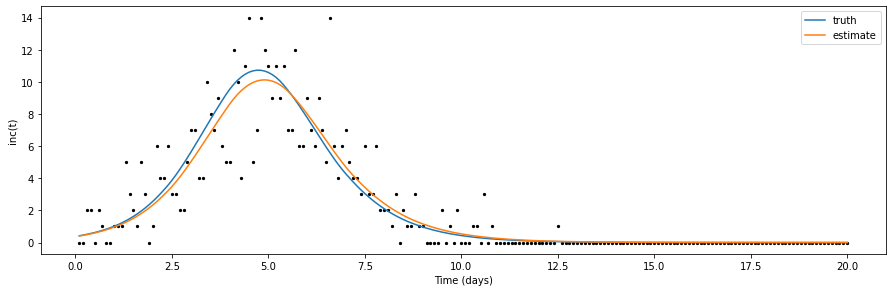

In [358]:
#--estimated incident cases
N                  = 1000 
initial_conditions = (0.999, 0.001, 0., 0.001)
start_end          = (0,20) 

estimated_parameters = (estimated_beta, estimated_gamma)
estimated_inc_cases  = generate_proposed_inc_cases(estimated_parameters, N, initial_conditions, start_end)

#--draw i(t)
fig, ax = plt.subplots()
fig.set_size_inches(12.5,12.5/3)

ax.plot(times[1:]   ,inc_cases, label="truth")
ax.scatter(times[1:],noisy_inc_cases, s=5, color="black")

ax.plot(times[1:]   ,estimated_inc_cases, label="estimate")

ax.legend()

#--set y and xlabel 
ax.set_xlabel("Time (days)", fontsize=10)
ax.set_ylabel("inc(t)", fontsize=10)

fig.set_tight_layout(True) #--adjust graph to fit labels

plt.show()

### HOMEWORK PROBEM 1

Please use the code above and reparamterize our model so that we input the parameters $R_{0}$ and $1/\gamma$ instead of the parameters $\beta$ and $\gamma$.
Generate noisy incident cases for the following setting:
- initial_conditions = (0.99, 0.10, 0.00, 0.10)
- $R_{0} = 2.75$ , $1 / \gamma = 2$, and $N=1000$
- start = 0 and end = 15

### HOMEWORK PROBLEM 2

Please rewrite the function that computes incident cases to accept the parameter $\mathcal{R}_{0}$ and $1/\gamma$ instead of $\beta$ and $\gamma$. 
Use this new function to fit our reparameterized SIR model to the noisy incident cases that you genertaed in HW problem one.
Plot the true number of incident cases, noisy observations, and estimated number of incident cases. 

### HOMEWORK PROBLEM 3

The last assignment will be to add an additional parameter to our model---$I(0)$.
Up until now we have assumed that we know the initial conditions exactly. 
Lets modify our code so that we estimate $\mathcal{R}_{0}$, $1 / \gamma$, and an additional parmaeter $I(0)$.

This means that we will not longer need to give our model fit initial conditions, our initial conditions are now a variable that needs to be optimized. 

Our new parameter $I(0)$ that we will introduce can cause some trouble for the `minimize` function---the variable I(0) can only be between the values 0 and 1. The variable $I(0)$ has **constraints**. 
To overcome this problem we will need to work with a **transformed version** of $I(0)$. 
Our transformed $I(0)$ will be the result of a function that maps values from $(-\infty,\infty)$ to $[0,1]$.
The minimization program will test values on the interval $(-\infty,\infty)$ and it will be our job to map those valus to the interval $[0,1]$. 

We know a function that can map real values to the interval 0 to one! The logistic function. 

\begin{align}
    l(x) = \frac{ e^{x} }{1 + e^{x}}
\end{align}

1. Update the function `generate_proposed_inc_cases`
    - Remove the inital_conditions argument
    - Change the parameter argument `R0_duration` to `R0_duration_transformedi0`
    - Compute initial conditions inside this function given the above variable `R0_duration_transformedi0`
        - Be sure to map the transformedi0 value to the interval [0,1] using the logistic function.   
2. Fit your model to the data. What happened? 